In [481]:
# Import library-library yang diperlukan
import cv2  # Untuk pemrosesan gambar
import mediapipe as mp  # Untuk deteksi landmark telapak tangan
import numpy as np  # Untuk operasi matematika
import matplotlib.pyplot as plt  # Untuk visualisasi
import os  # Untuk operasi file dan direktori
import tensorflow as tf
from scipy.spatial.distance import cosine
from glob import glob

## Tahap 1: Load dan Tampilkan Gambar Asli
### Pada tahap ini, kita akan:
### 1. Membaca file gambar menggunakan OpenCV
### 2. Mengubah format warna dari BGR ke RGB (OpenCV membaca dalam format BGR)
### 3. Menampilkan gambar asli untuk memastikan loading berhasil

In [482]:
def load_and_display_image(image_path):
    """
    Fungsi untuk membaca dan menampilkan gambar asli

    Parameters:
    image_path (str): Path ke file gambar

    Returns:
    array: Gambar dalam format RGB
    """
    # Baca gambar dengan OpenCV
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Tidak dapat membaca gambar: {image_path}")

    # Convert BGR ke RGB karena OpenCV membaca dalam format BGR
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tampilkan gambar
    plt.figure(figsize=(8,8))
    plt.imshow(image_rgb)
    plt.title('Gambar Asli')
    plt.axis('off')
    plt.show()

    return image_rgb

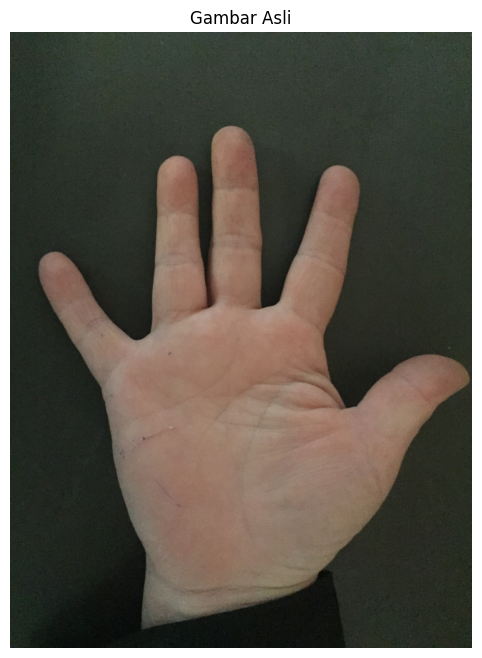

Ukuran gambar asli: (3264, 2448, 3)


In [483]:
image_path = "/CAPSTONE-PROJECT/data/raw/DATASET-032.jpg"
original_image = load_and_display_image(image_path)
print(f"Ukuran gambar asli: {original_image.shape}")

## Tahap 2: Deteksi Landmark Telapak Tangan
### Pada tahap ini, kita akan:
### 1. Menginisialisasi MediaPipe Hands untuk deteksi landmark
### 2. Mendeteksi 21 titik landmark pada telapak tangan
### 3. Memvisualisasikan landmark yang terdeteksi

### MediaPipe akan mendeteksi 21 titik pada tangan, termasuk:
### - Titik-titik pada setiap jari
### - Titik-titik pada telapak tangan
### - Koneksi antar titik

In [484]:
def detect_hand_landmarks(image_rgb):
    """
    Fungsi untuk mendeteksi landmark telapak tangan dengan rotasi otomatis
    jika gambar terbalik
    Returns:
    tuple: (landmarks, processed_image)
    """
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=1,
        min_detection_confidence=0.5
    )

    def is_upside_down(landmarks):
        """
        Cek apakah gambar tangan terbalik
        """
        wrist = landmarks.landmark[0]
        middle_finger_tip = landmarks.landmark[12]
        return wrist.y < middle_finger_tip.y

    # Proses gambar awal
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        landmarks = results.multi_hand_landmarks[0]
        image_to_process = image_rgb.copy()
        
        if is_upside_down(landmarks):
            height, width = image_rgb.shape[:2]
            center = (width // 2, height // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, 180, 1.0)
            image_to_process = cv2.warpAffine(image_rgb, rotation_matrix, (width, height))
            
            results = hands.process(image_to_process)
            if results.multi_hand_landmarks:
                landmarks = results.multi_hand_landmarks[0]
        
        image_with_landmarks = image_to_process.copy()
        mp_drawing.draw_landmarks(
            image_with_landmarks,
            landmarks,
            mp_hands.HAND_CONNECTIONS)
        
        plt.figure(figsize=(8,8))
        plt.imshow(image_with_landmarks)
        plt.title('Deteksi Landmark Tangan')
        plt.axis('off')
        plt.show()
        
        return landmarks, image_to_process
    else:
        print("Tidak ada landmark tangan yang terdeteksi!")
        return None, image_rgb


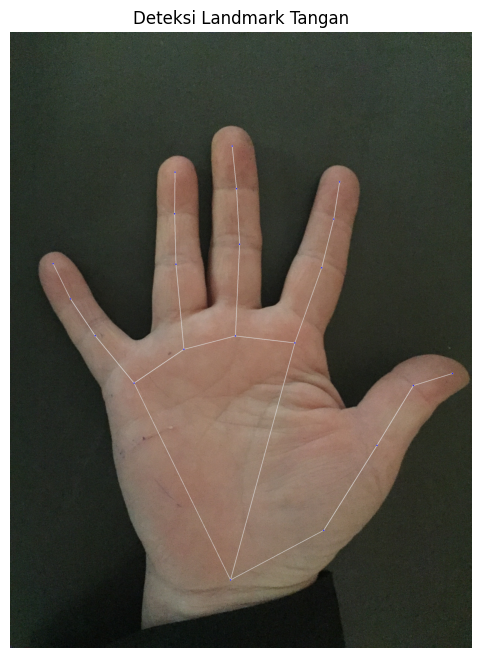

In [485]:
landmarks, processed_image = detect_hand_landmarks(original_image)

In [486]:
def extract_palm_roi(image_rgb, landmarks):
    """
    Fungsi untuk mengekstrak ROI telapak tangan
    Parameters:
    image_rgb (array): Gambar dalam format RGB
    landmarks (object): Objek landmark MediaPipe
    Returns:
    tuple: (ROI gambar, koordinat ROI (x1,y1,x2,y2))
    """
    if landmarks is None:
        return None, None
        
    h, w = image_rgb.shape[:2]
    
    # Ambil landmark pusat telapak tangan
    palm_center_indices = [1, 5, 9, 13, 17]
    palm_points = []
    
    for idx in palm_center_indices:
        landmark = landmarks.landmark[idx]
        x, y = int(landmark.x * w), int(landmark.y * h)
        palm_points.append((x, y))
    
    # Hitung pusat telapak tangan
    center_x = int(np.mean([p[0] for p in palm_points]))
    center_y = int(np.mean([p[1] for p in palm_points])) + 100
    
    # Hitung ukuran ROI
    palm_width = max([p[0] for p in palm_points]) - min([p[0] for p in palm_points])
    palm_height = max([p[1] for p in palm_points]) - min([p[1] for p in palm_points])
    roi_size = int(max(palm_width, palm_height) * 1.2)
    
    # Hitung koordinat ROI
    x1 = max(0, center_x - roi_size//2)
    y1 = max(0, center_y - roi_size//2)
    x2 = min(w, x1 + roi_size)
    y2 = min(h, y1 + roi_size)
    
    # Pastikan ROI berbentuk persegi
    roi_size = min(x2-x1, y2-y1)
    x2 = x1 + roi_size
    y2 = y1 + roi_size
    
    # Ekstrak ROI
    roi = image_rgb[y1:y2, x1:x2]
    
    # Visualisasi
    img_with_roi = image_rgb.copy()
    cv2.rectangle(img_with_roi, (x1,y1), (x2,y2), (0,255,0), 2)
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(img_with_roi)
    plt.title('Telapak Tangan dengan Kotak ROI')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(roi)
    plt.title(f'ROI Terekstrak {roi.shape[:2]}')
    plt.axis('off')
    plt.show()
    
    return roi, (x1,y1,x2,y2)

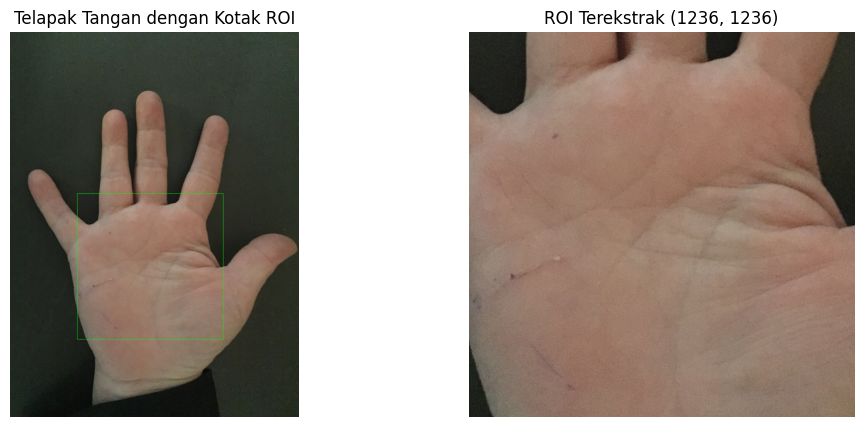

Koordinat ROI: (570, 1369, 1806, 2605)
Ukuran ROI: (1236, 1236, 3)


In [487]:
roi, coords = extract_palm_roi(processed_image, landmarks)
print(f"Koordinat ROI: {coords}")
print(f"Ukuran ROI: {roi.shape if roi is not None else 'None'}")

## Tahap 4: Konversi ke Grayscale
### Pada tahap ini, kita akan:
### 1. Mengkonversi gambar ROI dari RGB ke grayscale
### 2. Grayscale mengurangi kompleksitas dan memudahkan tahap preprocessing selanjutnya
### 3. Menyimpan informasi intensitas yang penting untuk analisis telapak tangan

In [488]:
def convert_to_grayscale(roi):
    """
    Fungsi untuk mengkonversi ROI ke grayscale dan menghilangkan bayangan
    dengan pemrosesan tambahan untuk hasil yang lebih optimal
    
    Keterangan:
    roi (array): Gambar ROI dalam format RGB
    alpha (float): Nilai kontras (range: 0.5-3.0)
    beta (int): Nilai brightness (range: -100 sampai 100)
    clip_limit (float): Batas kontras untuk CLAHE (range: 1.0-5.0)
    gamma (float): Nilai koreksi gamma (range: 0.5-2.0)
    dilate_kernel (int): Ukuran kernel dilasi (range: 3-21, harus ganjil)
    blur_kernel (int): Ukuran kernel blur (range: 3-31, harus ganjil)
    norm_min (int): Batas bawah normalisasi (range: 0-127)
    norm_max (int): Batas atas normalisasi (range: 128-255)
    
    Returns:
    array: Gambar ROI dalam format grayscale tanpa bayangan
    """
    if roi is None:
        return None
       
    # Konversi ke grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
   
    # Langkah 1: Pra-pemrosesan untuk meningkatkan kontras
    # Turunkan clipLimit untuk mengurangi noise
    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(8,8))  # Ubah ke 8,8 untuk area lebih besar
    gray = clahe.apply(gray)
   
    # Langkah 2: Penghilangan bayangan dengan kernel yang lebih besar
    dilated = cv2.dilate(gray, np.ones((5,5), np.uint8))  # Kurangi kernel size
    bg_img = cv2.medianBlur(dilated, 21)  # Kurangi blur kernel
   
    # Langkah 3: Penghilangan bayangan
    diff_img = 255 - cv2.absdiff(gray, bg_img)
   
    # Langkah 4: Peningkatan kontras hasil
    # Gunakan CLAHE dengan parameter yang lebih lembut
    clahe_final = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
    diff_img = clahe_final.apply(diff_img)
   
    # Langkah 5: Normalisasi dengan rentang yang lebih sempit
    normalized = cv2.normalize(diff_img, None, alpha=15, beta=240,
                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
   
    # Langkah 6: Final adjustment
    gamma = 0.5  # Nilai gamma yang lebih mendekati 1 untuk kontras lebih natural
    normalized = np.array(255 * (normalized / 255) ** gamma, dtype='uint8')
    
    # Opsional: Tambahkan median blur ringan di akhir jika masih ada noise
    normalized = cv2.medianBlur(normalized, 3)
    
    # Tampilkan hasil
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.imshow(roi)
    plt.title('ROI Original (RGB)')
    plt.axis('off')
   
    plt.subplot(132)
    plt.imshow(gray, cmap='gray')
    plt.title('ROI Grayscale')
    plt.axis('off')
   
    plt.subplot(133)
    plt.imshow(normalized, cmap='gray')
    plt.title('Grayscale Tanpa Bayangan')
    plt.axis('off')
   
    plt.show()
   
    return normalized

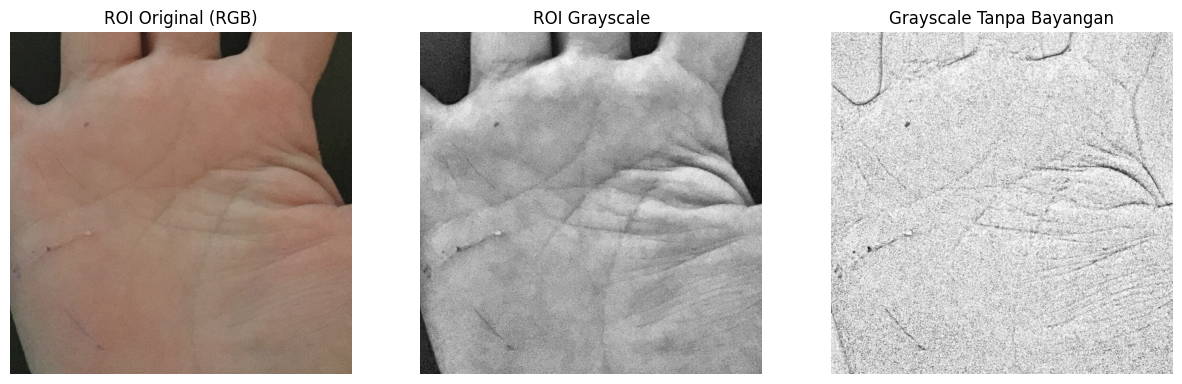

In [489]:
gray_roi = convert_to_grayscale(roi)

## Tahap 6: Resize ke Ukuran Standard
### Pada tahap ini, kita akan:
### 1. Mengubah ukuran gambar ke dimensi standard (128x128)
### 2. Ukuran standard memudahkan pemrosesan selanjutnya
### 3. Memastikan semua gambar memiliki ukuran yang sama
### 4. Mengurangi beban komputasi untuk proses selanjutnya

In [490]:
def resize_roi(enhanced_roi, target_size=(128, 128)):
    """
    Fungsi untuk mengubah ukuran ROI ke dimensi standard

    Parameters:
    enhanced_roi (array): Gambar ROI yang sudah ditingkatkan kontrasnya
    target_size (tuple): Ukuran target (width, height)

    Returns:
    array: Gambar ROI dengan ukuran standard
    """
    if enhanced_roi is None:
        return None

    # Resize gambar
    # INTER_AREA memberikan hasil terbaik untuk pengecilan gambar
    resized = cv2.resize(enhanced_roi, target_size, interpolation=cv2.INTER_AREA)

    # Tampilkan hasil
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.imshow(enhanced_roi, cmap='gray')
    plt.title(f'ROI Enhanced {enhanced_roi.shape}')
    plt.axis('off')

    plt.subplot(122)
    plt.imshow(resized, cmap='gray')
    plt.title(f'ROI Resized {resized.shape}')
    plt.axis('off')
    plt.show()

    return resized

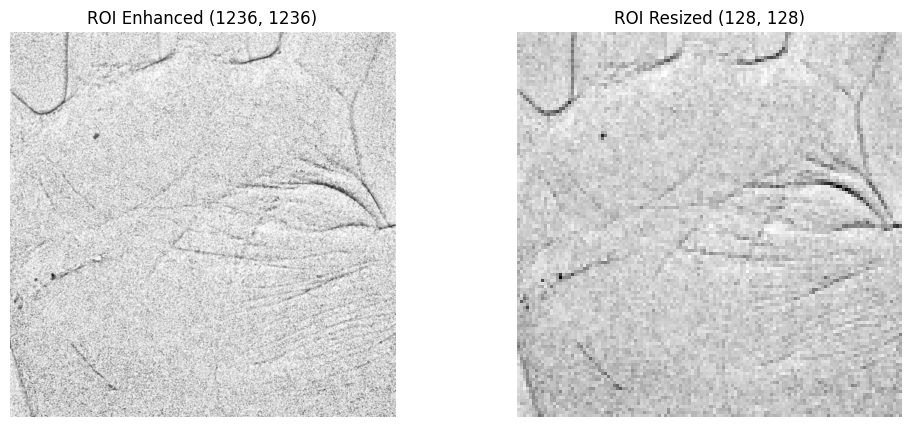

In [491]:
final_roi = resize_roi(gray_roi)

In [492]:
def augment_roi(image):
    """
    Fungsi untuk melakukan augmentasi pada gambar telapak tangan
    dengan berbagai teknik yang realistis dan tidak berlebihan
    """
    augmented = {}
    height, width = image.shape
    
    # Simpan gambar original
    augmented['original'] = image
    
    # 1. Rotasi dengan sudut kecil (±5°, ±10°)
    angles = [-15,-10, -5, 5, 10, 15]
    for angle in angles:
        M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
        rotated = cv2.warpAffine(image, M, (width, height),
                                borderMode=cv2.BORDER_REFLECT)
        augmented[f'rotate_{angle}°'] = rotated
    
    # 2. Scaling (0.95, 1.05, 1.1)
    scales = [0.95, 1.05, 1.1]
    for scale in scales:
        new_width = int(width * scale)
        new_height = int(height * scale)
        
        scaled = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        # Crop atau pad untuk mencapai ukuran original
        if scale > 1:
            start_y = (scaled.shape[0] - height) // 2
            start_x = (scaled.shape[1] - width) // 2
            scaled = scaled[start_y:start_y+height, start_x:start_x+width]
        else:
            pad_y = (height - scaled.shape[0]) // 2
            pad_x = (width - scaled.shape[1]) // 2
            scaled = cv2.copyMakeBorder(scaled, pad_y, pad_y, pad_x, pad_x, 
                                      cv2.BORDER_REFLECT)
        
        augmented[f'scale_{scale}'] = scaled
    
    # 3. Brightness adjustment (±5%, ±10%)
    brightnesses = [-25, -12, 12, 25]  # Nilai beta untuk brightness
    for beta in brightnesses:
        label = 'darker' if beta < 0 else 'brighter'
        intensity = '5%' if abs(beta) < 15 else '10%'
        adjusted = cv2.convertScaleAbs(image, alpha=1.0, beta=beta)
        augmented[f'{label}_{intensity}'] = adjusted
    
    # 4. Contrast adjustment (±5%, ±10%)
    contrasts = [1.05, 1.1, 1.15, 1.2]
    for alpha in contrasts:
        label = 'lower' if alpha < 1 else 'higher'
        intensity = '5%' if abs(alpha-1) < 0.1 else '10%'
        adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
        augmented[f'contrast_{label}_{intensity}'] = adjusted
    
    # 5. Kombinasi augmentasi sederhana
    # Rotasi + brightness
    for angle in [-5, 5]:
        for beta in [-12, 12]:
            M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
            rotated = cv2.warpAffine(image, M, (width, height),
                                   borderMode=cv2.BORDER_REFLECT)
            adjusted = cv2.convertScaleAbs(rotated, alpha=1.0, beta=beta)
            label = 'darker' if beta < 0 else 'brighter'
            augmented[f'rotate_{angle}°_{label}_5%'] = adjusted
    
    # Tampilkan hasil
    plt.figure(figsize=(20, 15))
    total_imgs = len(augmented)
    cols = 4
    rows = (total_imgs + cols - 1) // cols
    
    for idx, (aug_type, aug_image) in enumerate(augmented.items(), 1):
        plt.subplot(rows, cols, idx)
        plt.imshow(aug_image, cmap='gray')
        plt.title(f'Augmentation:\n{aug_type}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal augmented images generated: {len(augmented)}")
    for idx, aug_type in enumerate(augmented.keys(), 1):
        print(f"{idx}. {aug_type}")
    
    return augmented

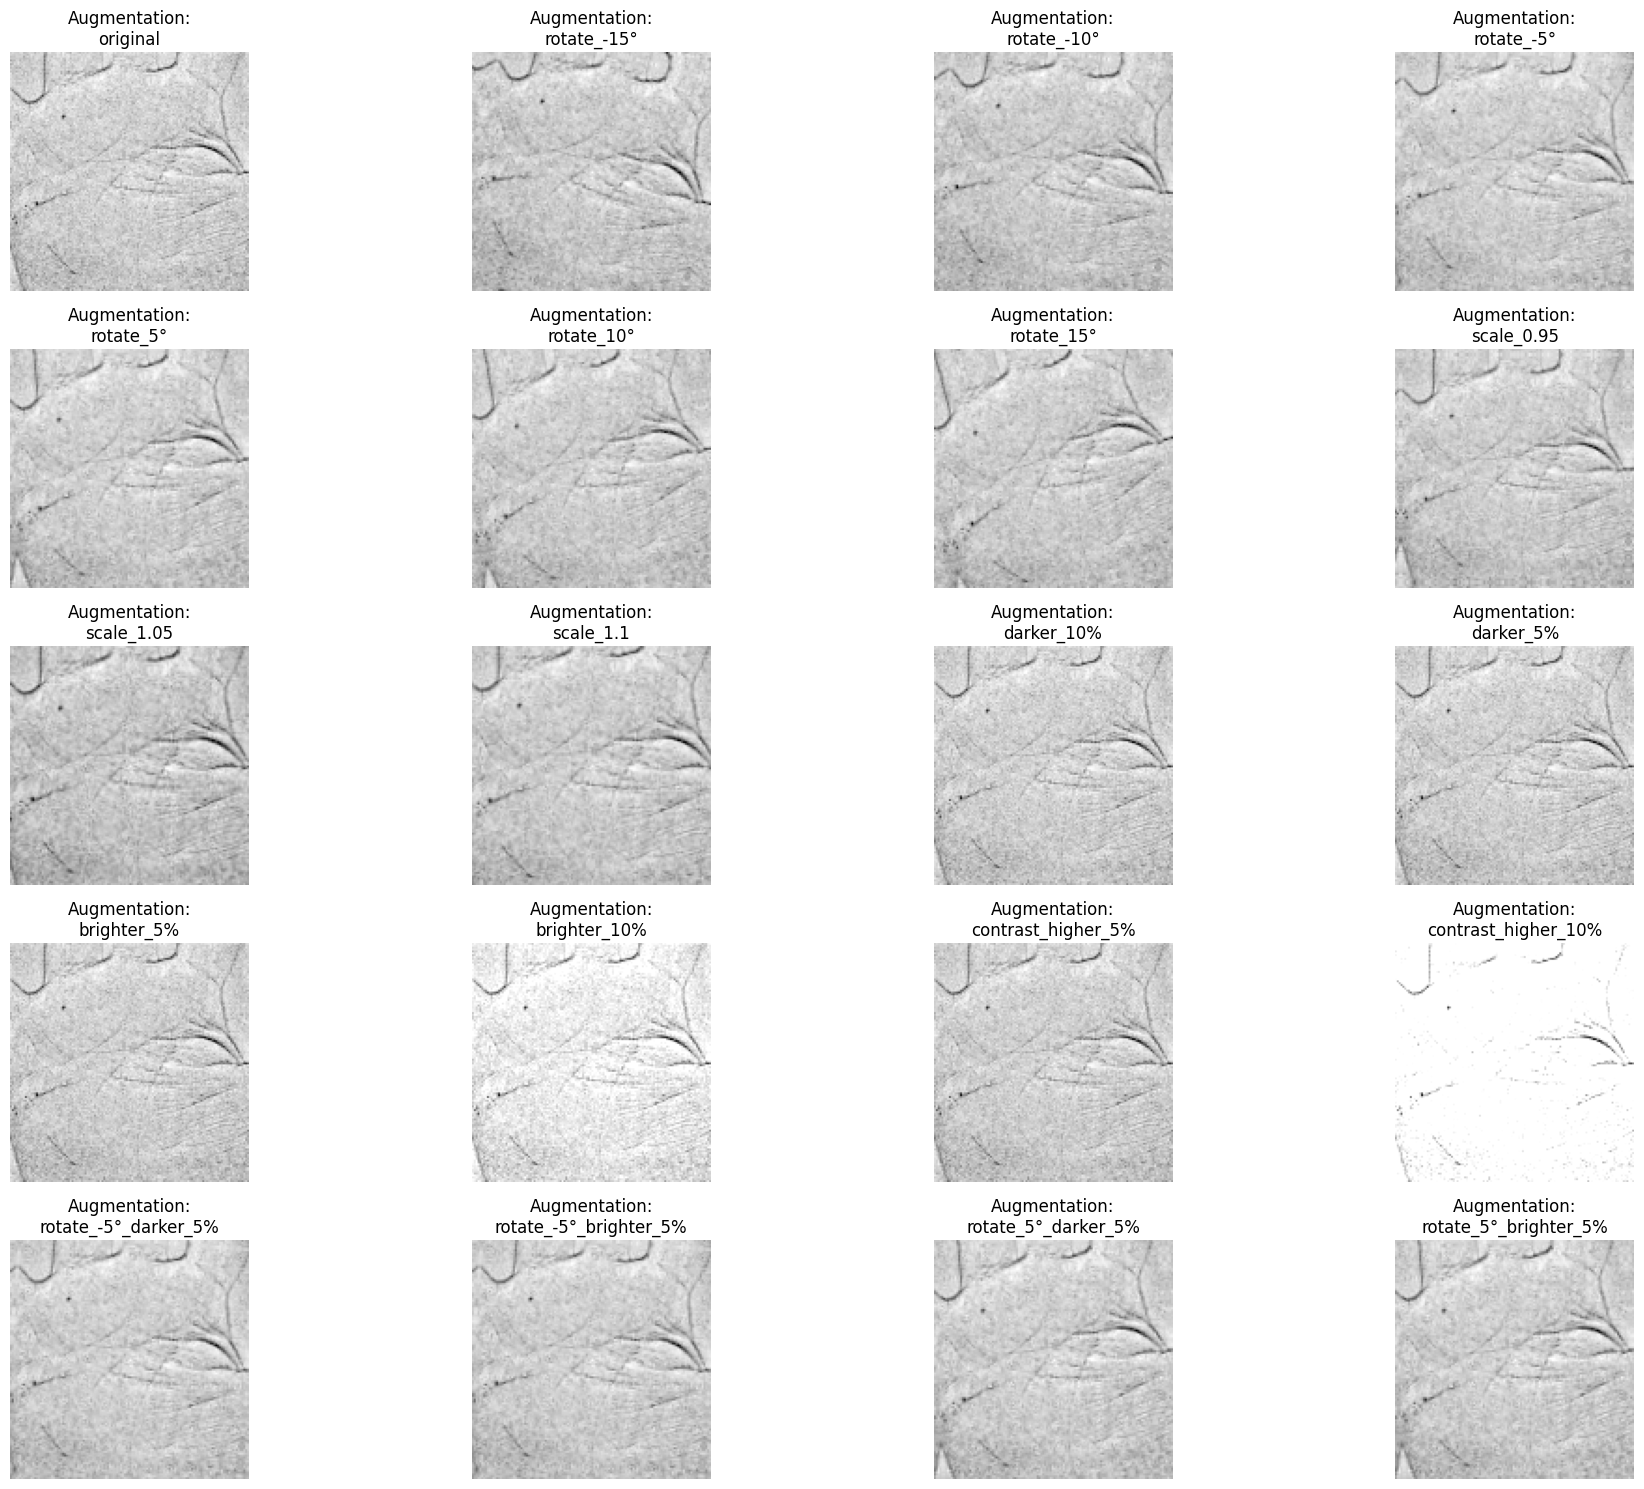


Total augmented images generated: 20
1. original
2. rotate_-15°
3. rotate_-10°
4. rotate_-5°
5. rotate_5°
6. rotate_10°
7. rotate_15°
8. scale_0.95
9. scale_1.05
10. scale_1.1
11. darker_10%
12. darker_5%
13. brighter_5%
14. brighter_10%
15. contrast_higher_5%
16. contrast_higher_10%
17. rotate_-5°_darker_5%
18. rotate_-5°_brighter_5%
19. rotate_5°_darker_5%
20. rotate_5°_brighter_5%


In [493]:
augmented_images = augment_roi(final_roi)

In [494]:
def save_augmented_images(augmented_dict, base_dir='/CAPSTONE-PROJECT/data'):
    """
    Menyimpan hasil augmentasi dengan person_id otomatis
    """
    # Buat direktori data/temp jika belum ada
    temp_dir = os.path.join(base_dir, 'aug')
    os.makedirs(temp_dir, exist_ok=True)
    
    # Cari person_id berikutnya
    existing_folders = glob(os.path.join(temp_dir, 'person_*'))
    person_id = f"{(len(existing_folders) + 1):03d}"
    
    # Buat dan simpan di folder baru
    save_dir = os.path.join(temp_dir, f'person_{person_id}')
    os.makedirs(save_dir, exist_ok=True)
    
    # Simpan setiap hasil augmentasi
    for idx, (_, image) in enumerate(augmented_dict.items(), 1):
        filename = f'data_{person_id}_{idx}.jpg'
        cv2.imwrite(os.path.join(save_dir, filename), image)
        print(f"Saved: {filename}")
    
    print(f"\nSaved {len(augmented_dict)} images in: person_{person_id}")
    return person_id

In [495]:
person_id = save_augmented_images(augmented_images)

Saved: data_032_1.jpg
Saved: data_032_2.jpg
Saved: data_032_3.jpg
Saved: data_032_4.jpg
Saved: data_032_5.jpg
Saved: data_032_6.jpg
Saved: data_032_7.jpg
Saved: data_032_8.jpg
Saved: data_032_9.jpg
Saved: data_032_10.jpg
Saved: data_032_11.jpg
Saved: data_032_12.jpg
Saved: data_032_13.jpg
Saved: data_032_14.jpg
Saved: data_032_15.jpg
Saved: data_032_16.jpg
Saved: data_032_17.jpg
Saved: data_032_18.jpg
Saved: data_032_19.jpg
Saved: data_032_20.jpg

Saved 20 images in: person_032
